In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random


import torch
import torchvision

import matplotlib.pyplot as plt  # Plotting
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier  # Classifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, mean_absolute_error, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from imblearn.over_sampling import RandomOverSampler as ROS # training data oversampling

#To show graphs within the notebook
%matplotlib inline 

In [8]:
# A useful funuction for plotting learning curves
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

# Importing the data
Here we can read the metadata into a pandas DataFrame to get the labels for our image data. 

In [3]:
# For readability: 
data = pd.read_csv('./archive/hmnist_28_28_RGB.csv')
data.head()
classes = {0: ('AK', 'Actinic Keratoses'),  
           1:('BC' , 'Basal Cell Carcinoma'), 
           2:('BKLL', 'Benign Keratosis-like Lesions'), 
           3: ('DF', 'Dermatofibroma'),
           4: ('MN', 'Melanocytic nevi'), 
           5: ('PGH', 'Pyogenic Granulomas and Hemorrhage'), 
           6: ('M', 'Melanoma'),
           }
CLASSES = [classes[idx][0] for idx in range(len(classes))] # abbreviated form of classes
CLASSES_FULL = [classes[idx][1] for idx in range(len(classes))] # Full name of classes
CLASSES, CLASSES_FULL


(['AK', 'BC', 'BKLL', 'DF', 'MN', 'PGH', 'M'],
 ['Actinic Keratoses',
  'Basal Cell Carcinoma',
  'Benign Keratosis-like Lesions',
  'Dermatofibroma',
  'Melanocytic nevi',
  'Pyogenic Granulomas and Hemorrhage',
  'Melanoma'])

# Visualizing the various classes
We should have an idea of what we're actually trying to classify first:

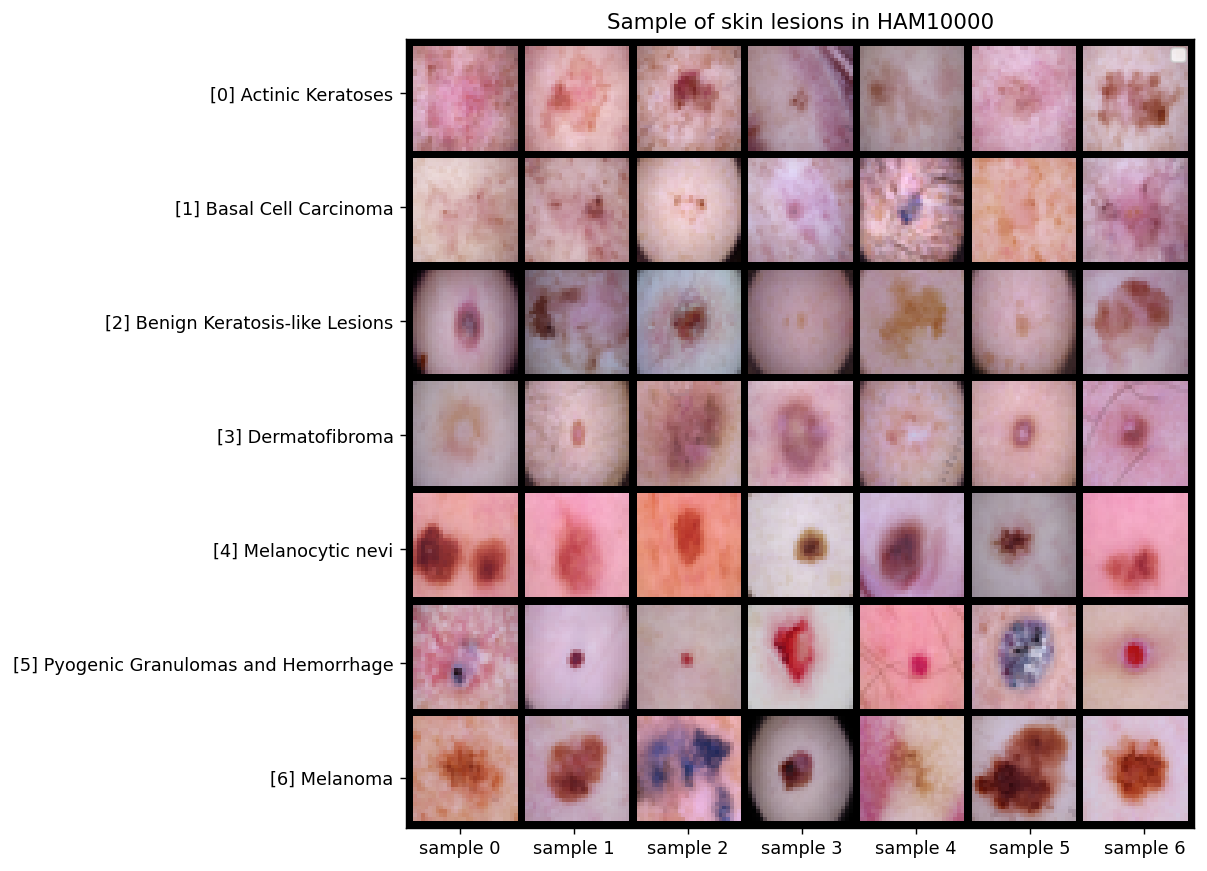

In [10]:
sample_images = []
N = len(CLASSES) # number of samples per class
for class_ in classes.keys():
    image_idxs = data.label==class_
    N_ = len(data[image_idxs])
    chosen = random.sample(list(np.arange(N_)), k= N) # creating random 7 samples per class
    images = np.asarray(data[image_idxs].iloc[chosen,:-1])# grabing those random 7 samples
    
    for img in images:
        sample_images.append(torch.tensor(img.reshape(28,28,3)).permute(2,0,1)) # obtaining one image at a time 
        
        
# Torch makes this way easier than with other frameworks as far as I can tell.
s = torch.stack(sample_images) # stack all images, convert to torch.tensor for grid
grid = torchvision.utils.make_grid(s, nrow=N) # Create a grid of images

# matplotlib wizardry
plt.figure(figsize=(8,8), dpi=(128)) # plot the grid
plt.imshow(grid.permute(1,2,0))
plt.xticks(np.linspace(14,grid.shape[2]-14,7), labels=[f'sample {idx}' for idx in range(N)])
plt.yticks(np.linspace(14,grid.shape[1]-14,7), labels=[f'[{idx}] {cls_}' for idx, cls_ in enumerate(CLASSES_FULL)])
plt.title('Sample of skin lesions in HAM10000')
plt.legend(CLASSES_FULL)
plt.show(block='off')

# Perform random oversampling to enable for more "fair" training.

/var/folders/16/_8tkc0kn25926rrc4z_87r700000gn/T/ipykernel_68941/4137319371.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  x_train.insert(0, 'label', value=y_train.values)


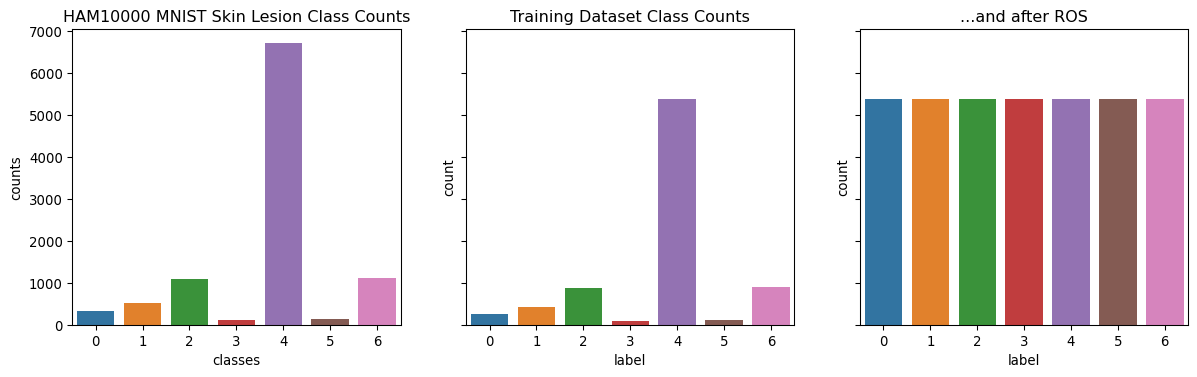

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(15,4), dpi=(96), sharex=True, sharey=True)

# Original dataset
x = data.drop(labels='label', axis=1) # drop the label column
y = data.label # get the label
# Plotting count
sns.countplot(x=data['label'], ax=ax[0])
ax[0].set(xlabel='classes', ylabel='counts')
ax[0].title.set_text('HAM10000 MNIST Skin Lesion Class Counts')


# Split original dataframe to training and testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# Plot number of samples in train split
x_train_ = x_train.copy()
x_train_.insert(0, 'label', value=y_train.values)
train_df_ = x_train_
sns.countplot(x=train_df_['label'], ax=ax[1])
ax[1].title.set_text('Training Dataset Class Counts')

# Create over sampler, and over sample ONLY the TRAIN dataframe
oversampler = ROS()
x_train, y_train = oversampler.fit_resample(x_train, y_train)

# Combine train image and label dataframe as one dataframe because my dataset requires it
x_train.insert(0, 'label', value=y_train.values)
train_df = x_train

# Combine test image and label dataframe as one dataframe because my dataset requires it
x_test.insert(0, 'label', value=y_test.values)
test_df = x_test

# Print number of samples in each train/test splits
len(train_df), len(test_df)

# Plot number of samples in train split (thats oversampled); all classes should have same number of counts
sns.countplot(x=train_df['label'], ax=ax[2])
ax[2].title.set_text('...and after ROS')
plt.show(block='off')

# Training a preliminary model

In [27]:
# training a basic random Forest
rf = RandomForestClassifier(n_estimators=200)
rf.fit(x_train,y_train)

RandomForestClassifier(n_estimators=200)

# Evaluating the model

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.41      0.55        69
           1       0.55      0.52      0.53        93
           2       0.58      0.44      0.50       228
           3       1.00      0.04      0.07        28
           4       0.81      0.97      0.88      1338
           5       1.00      0.05      0.09        21
           6       0.92      0.45      0.60       226

    accuracy                           0.79      2003
   macro avg       0.82      0.41      0.46      2003
weighted avg       0.79      0.79      0.76      2003



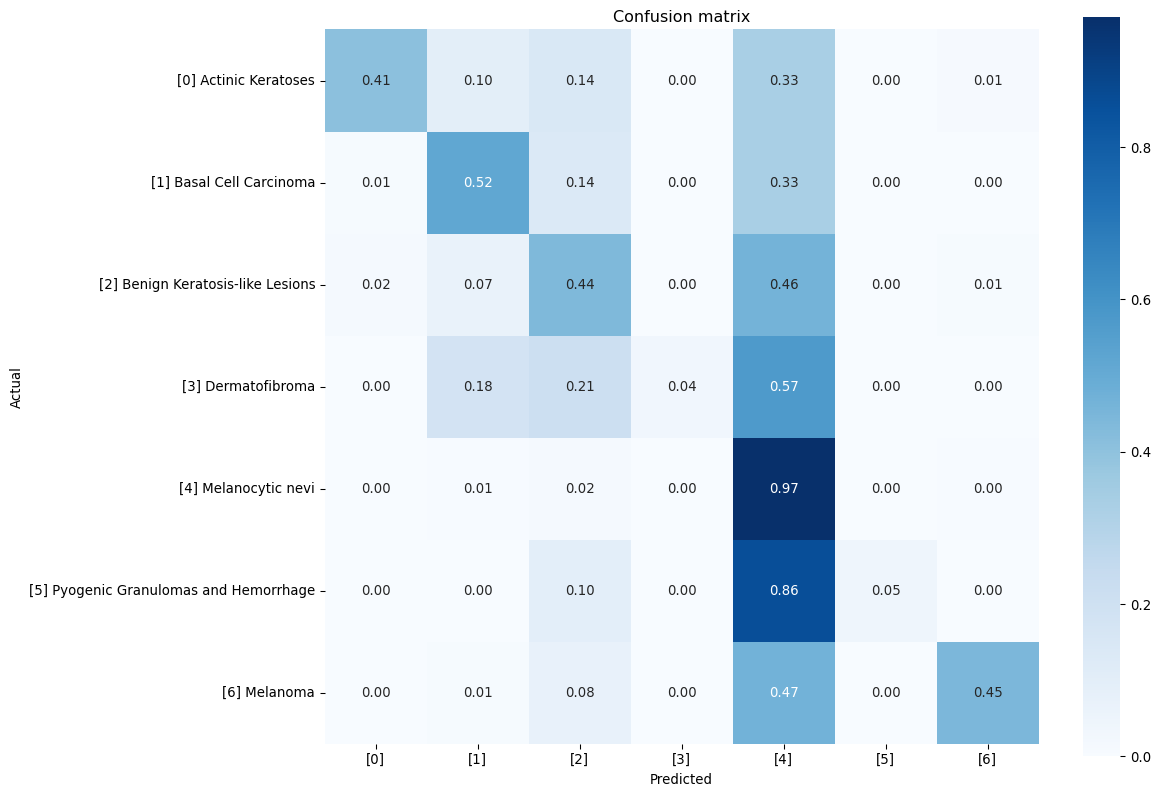

In [23]:
pred=rf.predict(x_test)

print ("Classification Report")
print(classification_report(y_test, pred))

conf_mat = confusion_matrix(y_test, pred)
# Plot confusion matrix
cmn = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis] # Normalise to convert count to percentage of counts
fig, ax = plt.subplots(figsize=(12,10), dpi=(96))

plt.imshow(cmn, interpolation='nearest', cmap=plt.cm.Blues)

sns.heatmap(cmn, cmap='Blues', annot=True, fmt='.2f', xticklabels=[f'[{idx}]' for idx in range(len(CLASSES))], yticklabels=[f'[{idx}] {cls}' for idx, cls in enumerate(CLASSES_FULL)])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.show(block=False)

# Discussion
We can see that our overall accuracy is around 79%, which is decent. However, Melanocytic Nevi is being predicted a significant portion of the time, while we're struggling to classify Dermatofibroma.

We can try doing a gridsearch over a few more hyperparameters such as maximum depth and the maximum number of features to refine our model, and see how it compares.

In [ ]:
# rfc=RandomForestClassifier(random_state=42)

# param_grid = { 
#     'n_estimators': [1, 50, 100, 200, 400],
#     'max_features': ['sqrt', 'log2'],
#     'max_depth': [4,5,6,7,8],
#     'criterion' :['gini', 'entropy', 'log_loss']
# }

# CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
# CV_rfc.fit(x_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [1, 50, 100, 200, 400]})

In [ ]:
# CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 400}

In [5]:
# Build a model using the parameters that we found
rf = RandomForestClassifier(n_estimators=400, criterion='entropy', max_depth=8, max_features='sqrt')
rf.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=400)

Classification Report
              precision    recall  f1-score   support

           0       0.28      0.46      0.35        69
           1       0.34      0.66      0.45        93
           2       0.47      0.50      0.49       228
           3       0.23      0.32      0.27        28
           4       0.95      0.69      0.80      1338
           5       0.61      0.52      0.56        21
           6       0.38      0.72      0.50       226

    accuracy                           0.66      2003
   macro avg       0.47      0.55      0.49      2003
weighted avg       0.76      0.66      0.69      2003



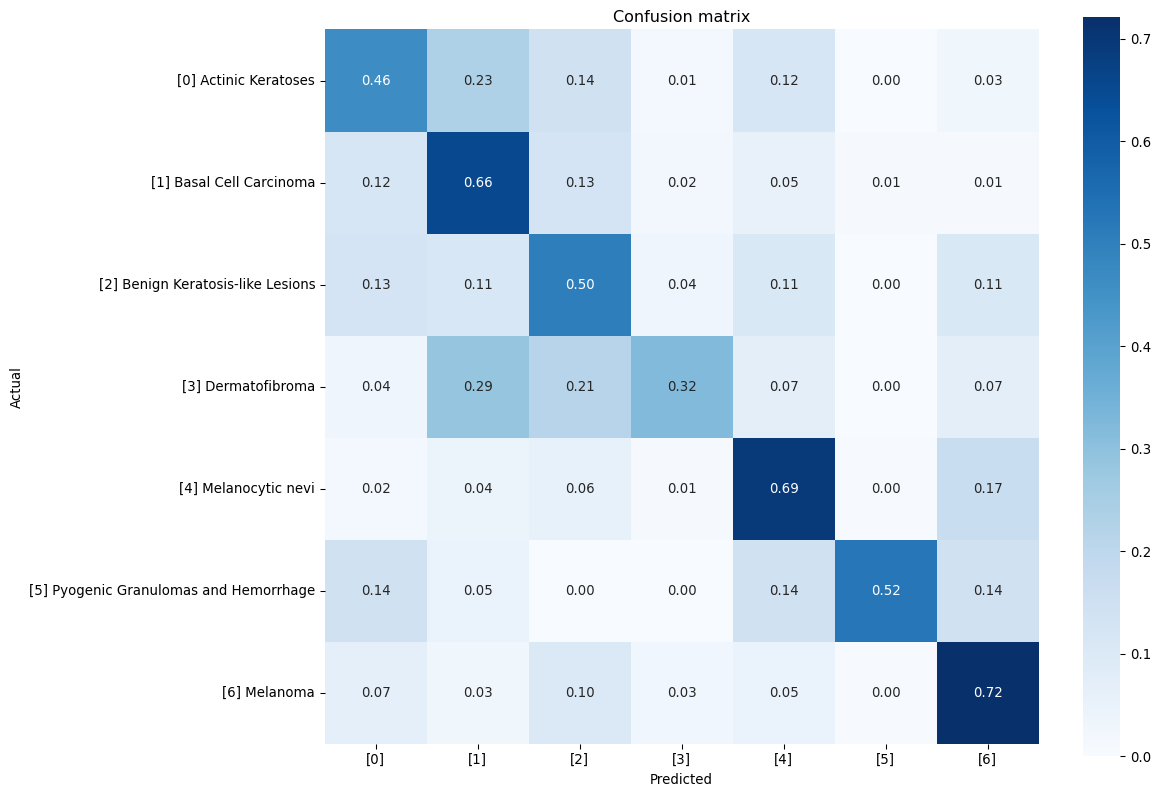

Precision, Recall, FScore, Support train_test_split:
 (array([0.27586207, 0.34269663, 0.47131148, 0.23076923, 0.94506612,
       0.61111111, 0.38352941]), array([0.46376812, 0.65591398, 0.50438596, 0.32142857, 0.69431988,
       0.52380952, 0.72123894]), array([0.34594595, 0.4501845 , 0.48728814, 0.26865672, 0.80051702,
       0.56410256, 0.50076805]), array([  69,   93,  228,   28, 1338,   21,  226]))

Mean Absolute Error using train_test_split: 0.7993010484273589

Precision, Recall, FScore, Support:
 (array([0.85319627, 0.89765458, 0.90738061, 0.94840078, 0.96548418,
       0.99495892, 0.87453875]), array([0.98975219, 0.94130799, 0.81777529, 1.        , 0.75051239,
       0.99291969, 0.92733371]), array([0.91641508, 0.91896317, 0.86025088, 0.97351714, 0.84453297,
       0.99393826, 0.90016278]), array([5367, 5367, 5367, 5367, 5367, 5367, 5367]))

Mean Absolute Error using just predictions: 0.18307647262370572


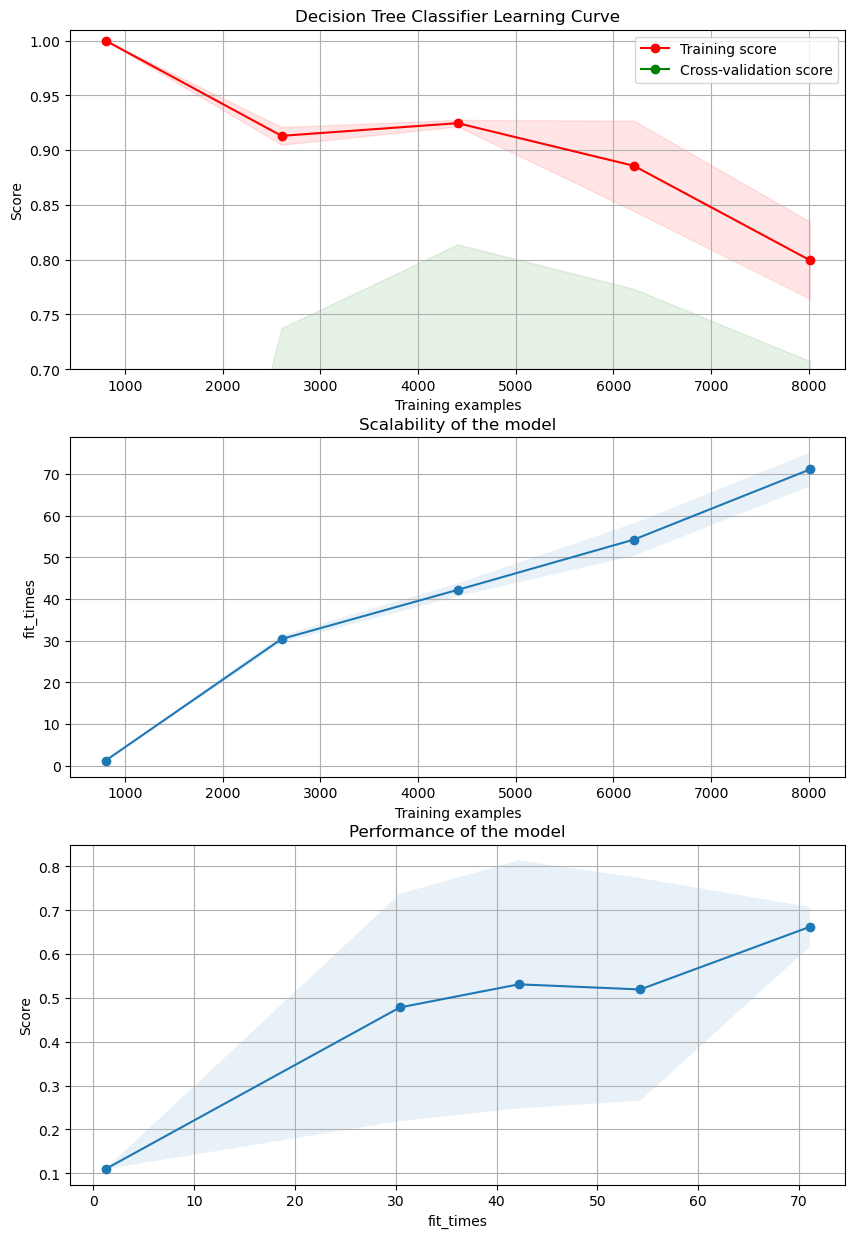

In [26]:
pred=rf.predict(x_test)
print ("Classification Report")
print(classification_report(y_test, pred))

conf_mat = confusion_matrix(y_test, pred)

# Plot confusion matrix
cmn = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis] # Normalise to convert count to percentage of counts
fig, ax = plt.subplots(figsize=(12,10), dpi=(96))

plt.imshow(cmn, interpolation='nearest', cmap=plt.cm.Blues)

sns.heatmap(cmn, cmap='Blues', annot=True, fmt='.2f', xticklabels=[f'[{idx}]' for idx in range(len(CLASSES))], yticklabels=[f'[{idx}] {cls}' for idx, cls in enumerate(CLASSES_FULL)])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.show(block=False)

test_predictions = rf.predict(x_test)
train_predictions = rf.predict(x_train)
print(f'Precision, Recall, FScore, Support train_test_split:\n {precision_recall_fscore_support(y_test, test_predictions)}\n')
print(f'Mean Absolute Error using train_test_split: {mean_absolute_error(y_test, test_predictions)}\n')
print(f'Precision, Recall, FScore, Support:\n {precision_recall_fscore_support(y_train, train_predictions)}\n')
print(f'Mean Absolute Error using just predictions: {mean_absolute_error(y_train, train_predictions)}')

fig, axes = plt.subplots(3,1, figsize=(10, 15))

title = 'Decision Tree Classifier Learning Curve'

plot_learning_curve(rf, title, x, y, axes=axes, ylim=(0.7, 1.01),
                    cv=None, n_jobs=4)

plt.show()


# Discussion of new model
While our overall accuracy saw a slight reduction, our confusion matrix looks much better now. It seems that the model is no longer guessing that most lesions are in class 4, and is instead beginning to extract actual features.

In [ ]:
# Cross validation
rf.fit(x, y)
score = cross_val_score(rf, x, y)
print (np.mean(score))


0.6601098352471293


<AxesSubplot:>

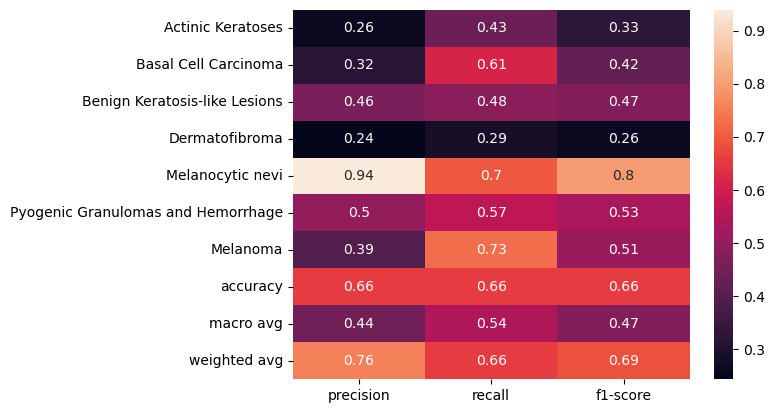

In [16]:
pred=rf.predict(x_test)

c_rep = classification_report(y_test, pred, labels=np.arange(len(CLASSES_FULL)), target_names=CLASSES_FULL, output_dict=True)
sns.heatmap(pd.DataFrame(c_rep).iloc[:-1, :].T, annot=True)
